# Download dataset

In [1]:
!pip install -q kaggle

from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"makeitperfect","key":"c8bc35c6430a6c8c8d6993623a45fe1e"}'}

In [2]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 10.5 MB/s eta 0:00:00


In [3]:
# Setting up Kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

# Download dataset
! kaggle competitions download -c airbnb-recruiting-new-user-bookings

! unzip airbnb-recruiting-new-user-bookings.zip
! unzip age_gender_bkts.csv.zip
! unzip countries.csv.zip
! unzip sample_submission_NDF.csv.zip
! unzip sessions.csv.zip
! unzip test_users.csv.zip
! unzip train_users_2.csv.zip

 93% 60.0M/64.7M [00:00<00:00, 72.2MB/s]
100% 64.7M/64.7M [00:01<00:00, 65.3MB/s]
Archive:  airbnb-recruiting-new-user-bookings.zip
  inflating: age_gender_bkts.csv.zip  
  inflating: countries.csv.zip       
  inflating: sample_submission_NDF.csv.zip  
  inflating: sessions.csv.zip        
  inflating: test_users.csv.zip      
  inflating: train_users_2.csv.zip   
Archive:  age_gender_bkts.csv.zip
  inflating: age_gender_bkts.csv     
Archive:  countries.csv.zip
  inflating: countries.csv           
Archive:  sample_submission_NDF.csv.zip
  inflating: sample_submission_NDF.csv  
Archive:  sessions.csv.zip
  inflating: sessions.csv            
Archive:  test_users.csv.zip
  inflating: test_users.csv          
Archive:  train_users_2.csv.zip
  inflating: train_users_2.csv       


In [4]:
# remove zip files
! rm -rf airbnb-recruiting-new-user-bookings.zip age_gender_bkts.csv.zip countries.csv.zip sample_submission_NDF.csv.zip sessions.csv.zip test_users.csv.zip train_users_2.csv.zip

# Importing dataset

In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random

from sklearn.preprocessing import OrdinalEncoder, LabelEncoder, label_binarize, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, ndcg_score

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (10, 6)

In [6]:
df = pd.read_csv('train_users_2.csv', parse_dates=[1,3])
test_df = pd.read_csv('test_users.csv', parse_dates=[1,3])
#sessions_df = pd.read_csv('sessions.csv')

In [7]:
df

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,gxn3p5htnn,2010-06-28,20090319043255,NaT,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
1,820tgsjxq7,2011-05-25,20090523174809,NaT,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF
2,4ft3gnwmtx,2010-09-28,20090609231247,2010-08-02,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US
3,bjjt8pjhuk,2011-12-05,20091031060129,2012-09-08,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other
4,87mebub9p4,2010-09-14,20091208061105,2010-02-18,-unknown-,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
213446,zxodksqpep,2014-06-30,20140630235636,NaT,MALE,32.0,basic,0,en,sem-brand,google,omg,Web,Mac Desktop,Safari,NDF
213447,mhewnxesx9,2014-06-30,20140630235719,NaT,-unknown-,NaN,basic,0,en,direct,direct,linked,Web,Windows Desktop,Chrome,NDF
213448,6o3arsjbb4,2014-06-30,20140630235754,NaT,-unknown-,32.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,NDF
213449,jh95kwisub,2014-06-30,20140630235822,NaT,-unknown-,NaN,basic,25,en,other,other,tracked-other,iOS,iPhone,Mobile Safari,NDF


# Data exploration

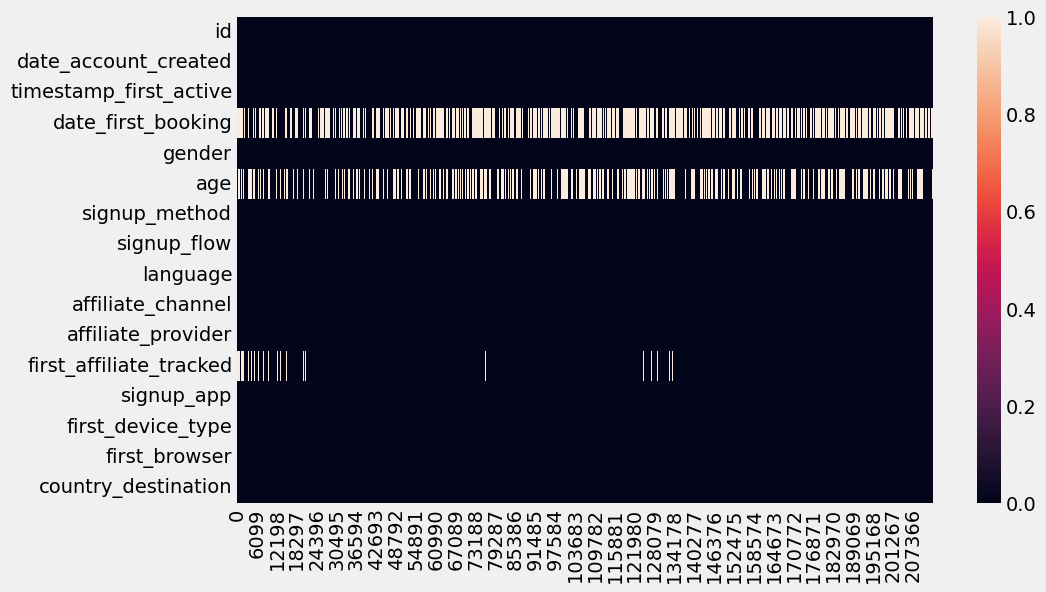

In [ ]:
sns.heatmap(df.isna().T);

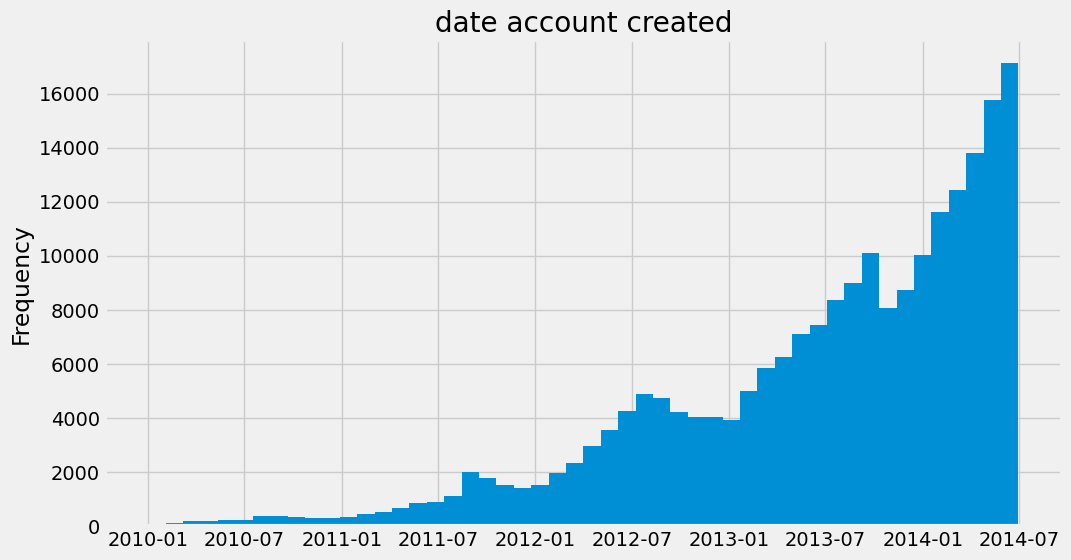

In [ ]:
df['date_account_created'].hist(bins=50, figsize=(11,6));
plt.ylabel('Frequency');
plt.title('date account created');

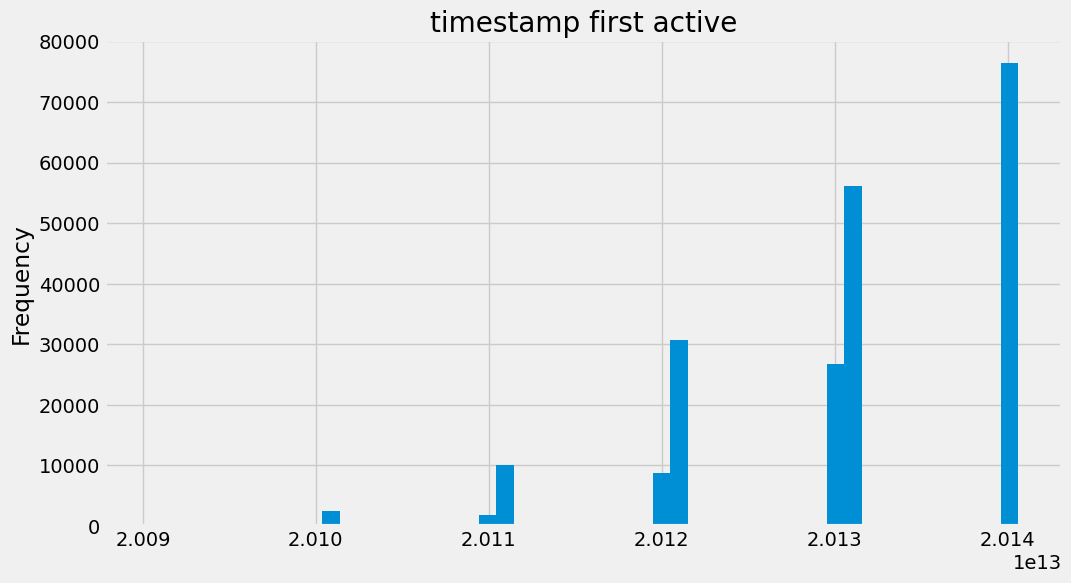

In [ ]:
df['timestamp_first_active'].hist(bins=50, figsize=(11,6));
plt.ylabel('Frequency');
plt.title('timestamp first active');

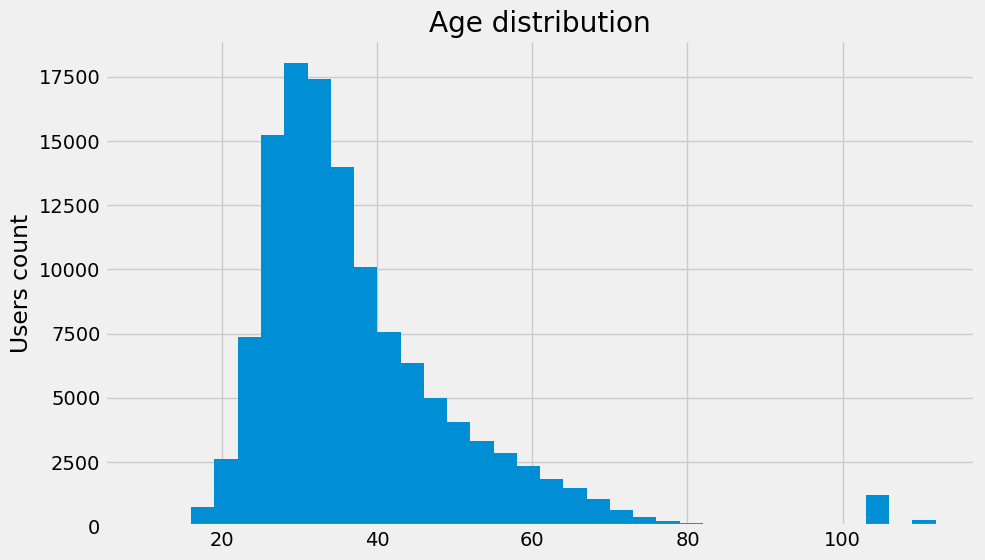

In [ ]:
binwidth = 3
df.age.dropna().hist(range=(10, 110),bins=range(10, 110 + binwidth, binwidth));
plt.rcParams["figure.figsize"] = (10,7)
plt.title('Age distribution')
plt.ylabel('Users count');

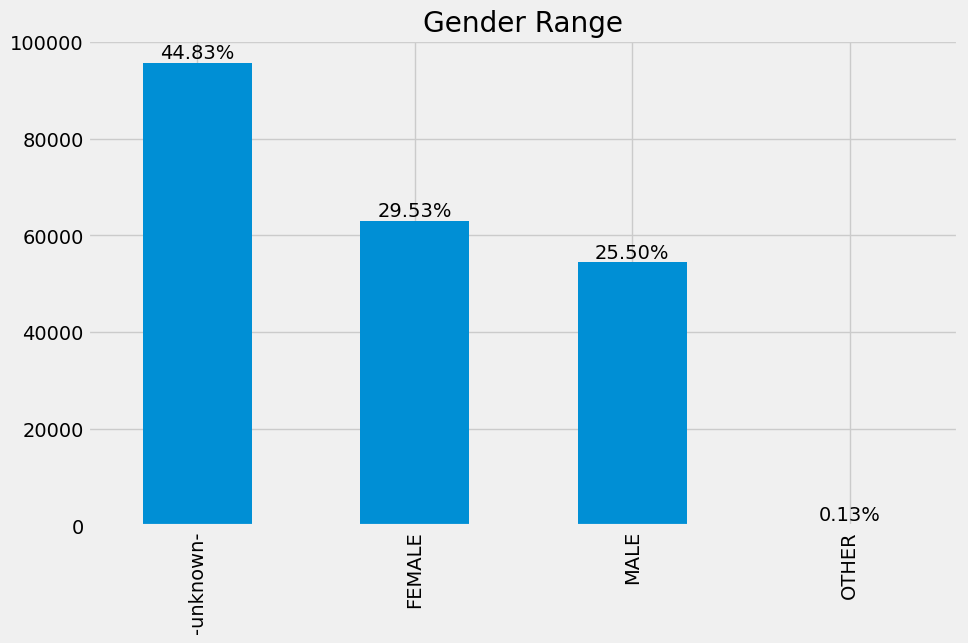

In [ ]:
gender_counts = df.gender.value_counts()
total_counts = gender_counts.sum()

ax = gender_counts.plot(kind='bar', title='Gender Range')

for i, count in enumerate(gender_counts):
    percentage = count / total_counts * 100
    ax.text(i, count, f"{percentage:.2f}%", ha='center', va='bottom')

plt.show()

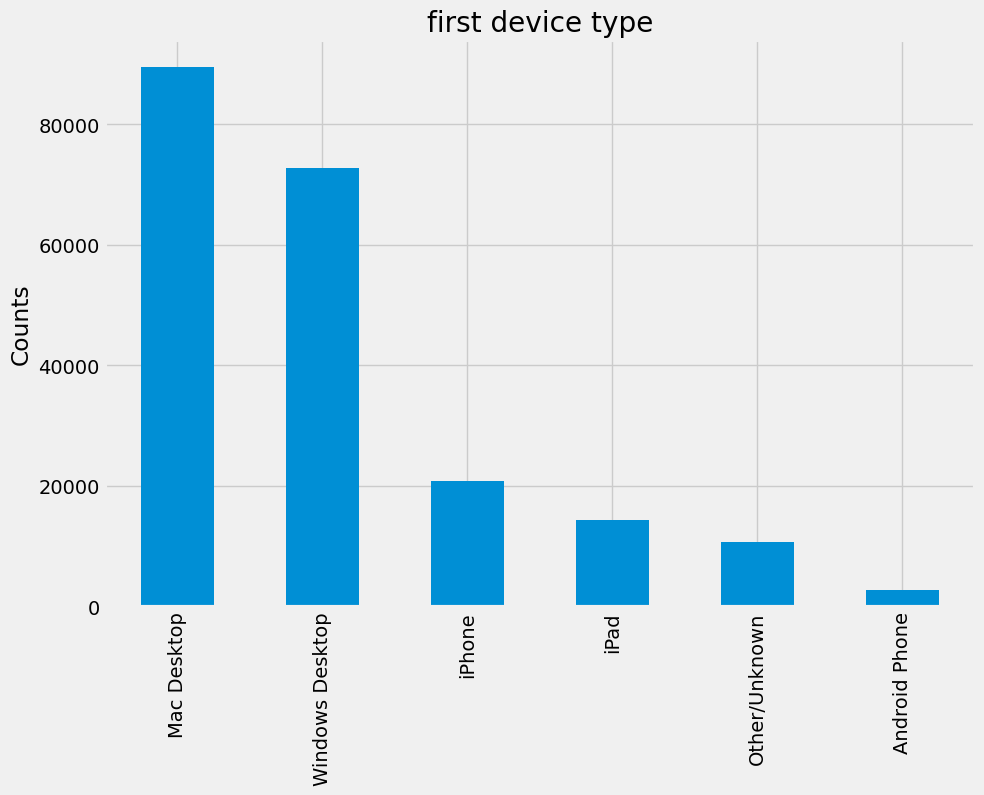

In [ ]:
df.first_device_type.value_counts()[:6].plot(kind='bar', title='first device type');
plt.ylabel('Counts');

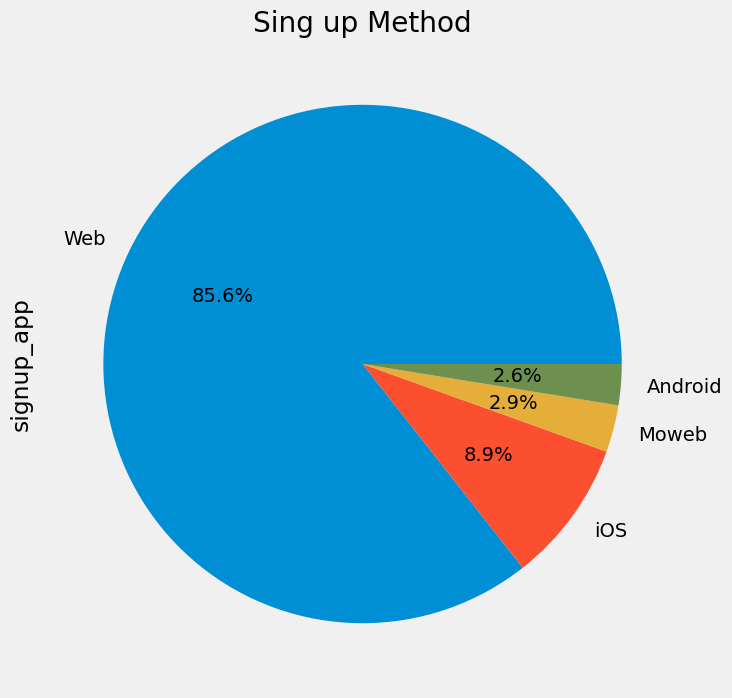

In [ ]:
df.signup_app.value_counts().plot(kind='pie', figsize=(10,8), title='Sing up Method', autopct='%1.1f%%');

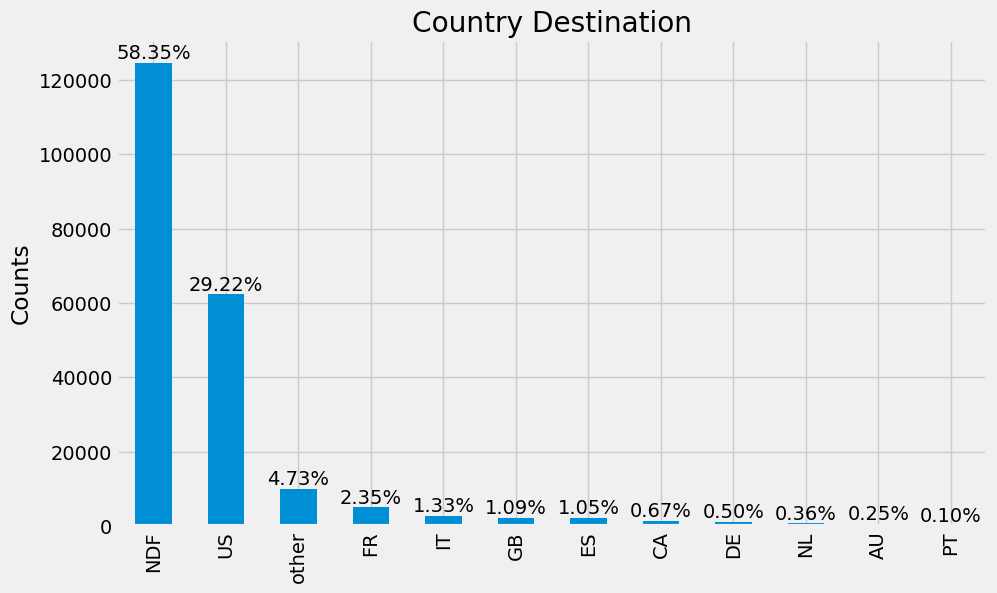

In [ ]:
country_counts = df.country_destination.value_counts()
total_counts = country_counts.sum()

ax = country_counts.plot(kind='bar')

for i, count in enumerate(country_counts):
    percentage = count / total_counts * 100
    ax.text(i, count, f"{percentage:.2f}%", ha='center', va='bottom')

plt.title('Country Destination')
plt.ylabel('Counts')

plt.show()

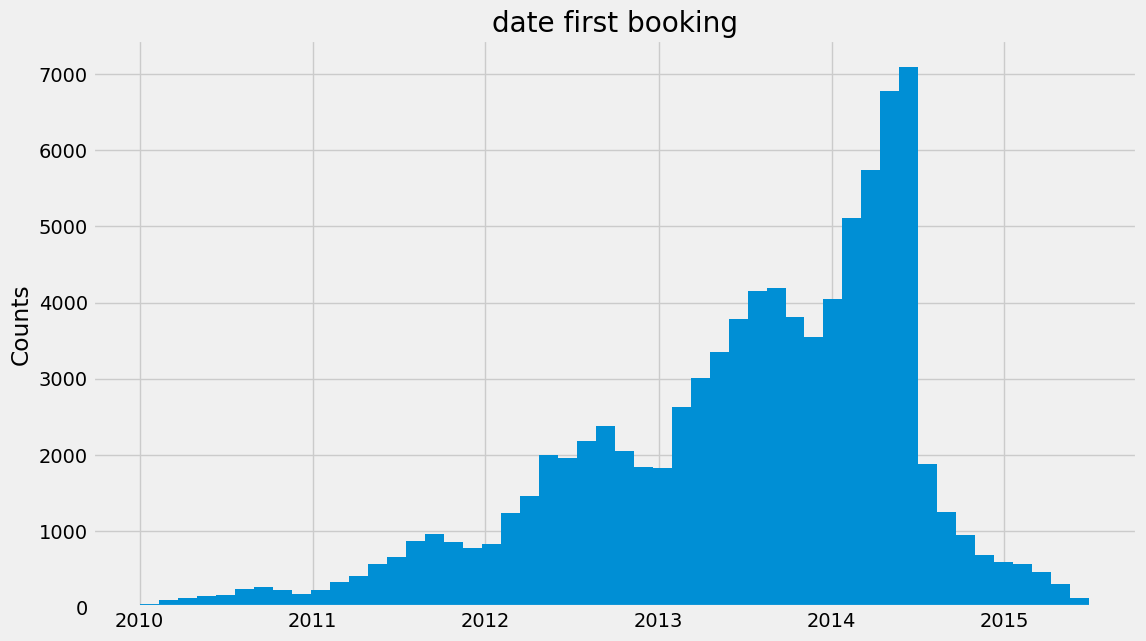

In [ ]:
df['date_first_booking'].hist(bins=50, figsize=(12,7));
plt.ylabel('Counts');
plt.title('date first booking');

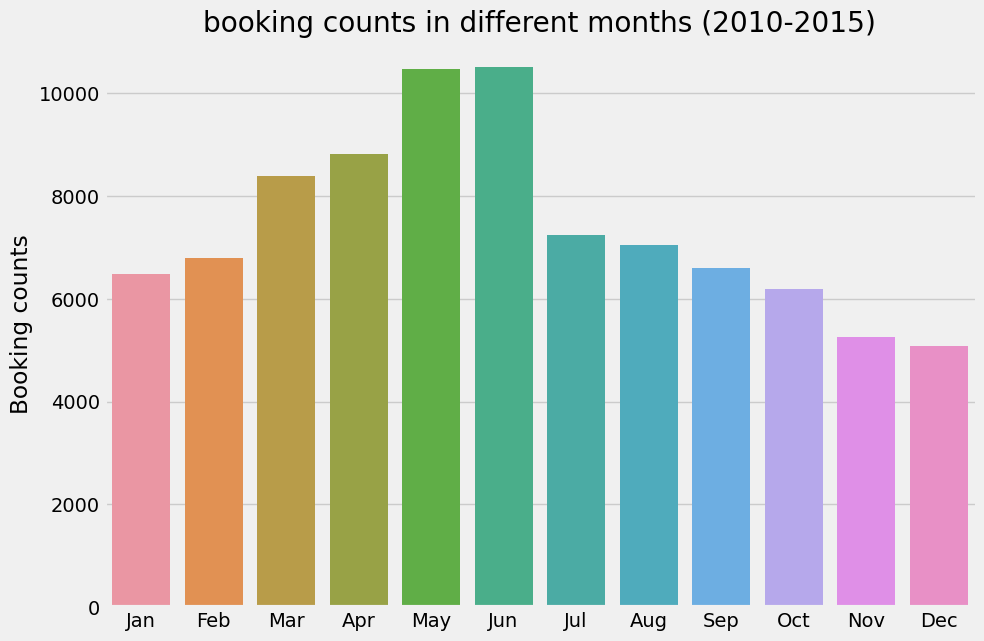

In [ ]:
months = []
for date in df.date_first_booking:
    months.append(date.month)
months = pd.Series(months)


sns.barplot(x = months.value_counts().index, y=months.value_counts().values, order=range(1,13))
plt.title('booking counts in different months (2010-2015)')
plt.ylabel('Booking counts')
plt.xticks(range(0, 12), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
sns.despine()

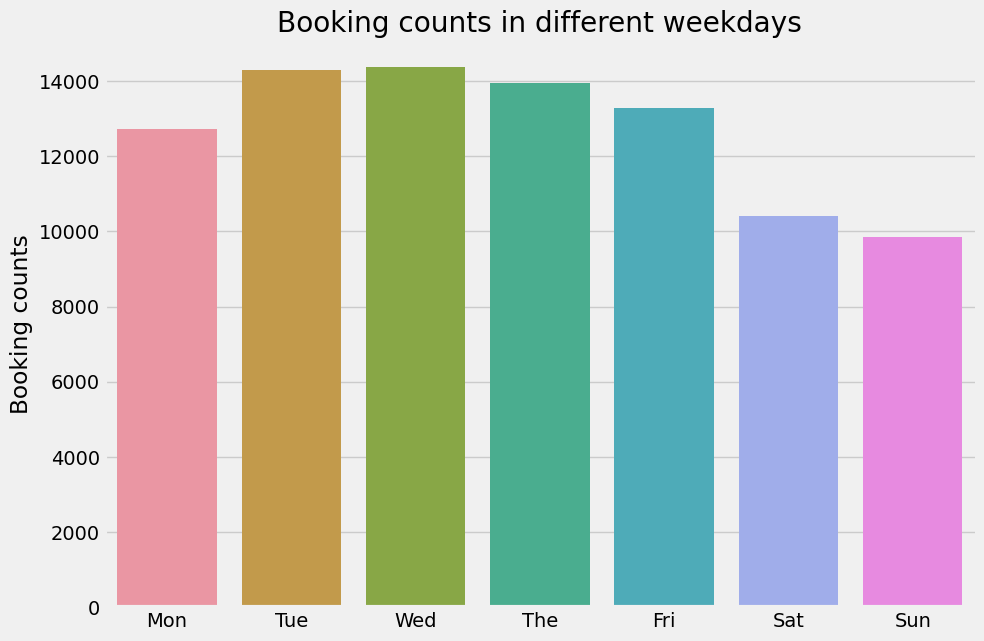

In [ ]:
weekdays = []
for date in df.date_first_booking:
    weekdays.append(date.weekday())
weekdays = pd.Series(weekdays)

sns.barplot(x=weekdays.value_counts().index, y=weekdays.value_counts().values, order=range(0, 7))
plt.title('Booking counts in different weekdays')
plt.ylabel('Booking counts')
plt.xticks(range(0, 7), ['Mon', 'Tue', 'Wed', 'The', 'Fri', 'Sat', 'Sun'])
sns.despine()

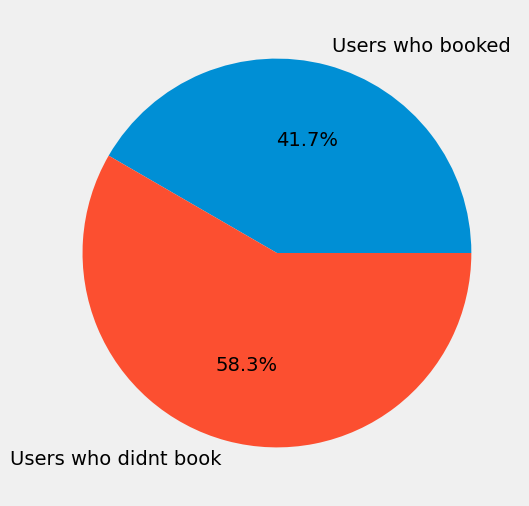

In [ ]:
dest = df.country_destination
not_booked = len(dest[dest=='NDF'])
total_booked = len(dest[dest!='NDF'])

plt.pie([total_booked, not_booked], labels=['Users who booked', 'Users who didnt book'], autopct='%1.1f%%');

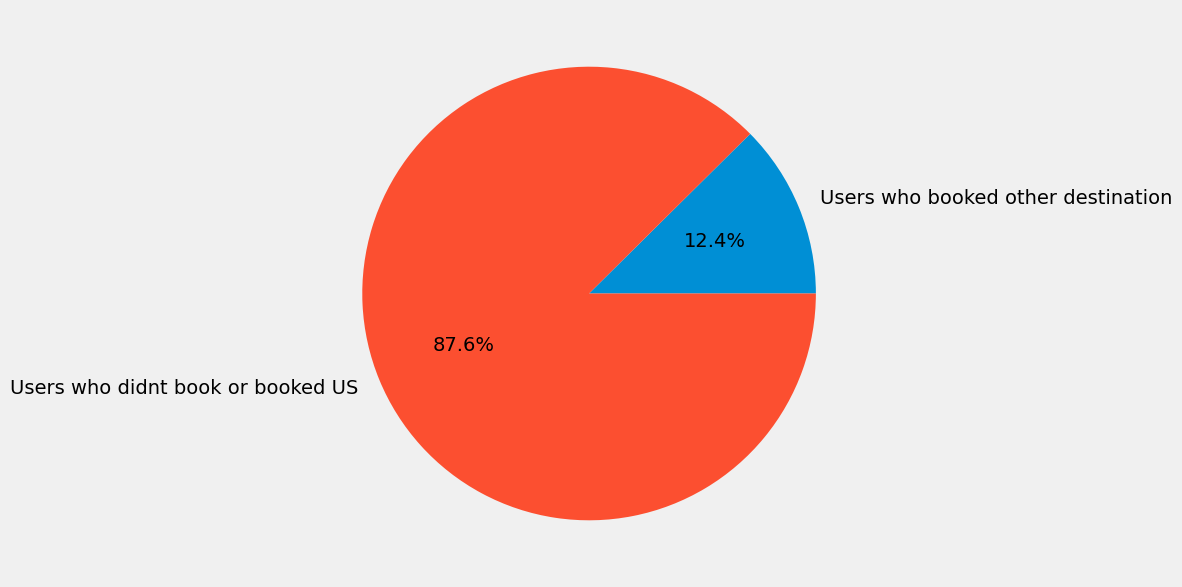

In [ ]:
dest = df.country_destination

not_booked_use = len(dest[dest=='US']) + len(dest[dest=='NDF'])
other_dest = len(dest[(dest!='NDF') & (dest!='US')])

plt.pie([other_dest, not_booked_use], labels=['Users who booked other destination', 'Users who didnt book or booked US'], autopct='%1.1f%%')
plt.show()

In [ ]:
#df.age.value_counts().plot(kind='hist', title='Age range:');

In [ ]:
#sns.countplot(df, x='country_destination', hue='gender');

In [ ]:
## About people's actions

# df.signup_method.value_counts().plot(kind='pie', figsize=(10,8),autopct='%1.1f%%');

In [ ]:
#df.signup_flow.value_counts().plot(kind='pie', figsize=(10,8), title='The page a user came to signup up from', autopct='%1.1f%%');

In [ ]:
# df.first_browser.value_counts()[:6].plot(kind='bar', title='First browser used by users');

# Data processing

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 213451 entries, 0 to 213450
Data columns (total 16 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   id                       213451 non-null  object        
 1   date_account_created     213451 non-null  datetime64[ns]
 2   timestamp_first_active   213451 non-null  int64         
 3   date_first_booking       88908 non-null   datetime64[ns]
 4   gender                   213451 non-null  object        
 5   age                      125461 non-null  float64       
 6   signup_method            213451 non-null  object        
 7   signup_flow              213451 non-null  int64         
 8   language                 213451 non-null  object        
 9   affiliate_channel        213451 non-null  object        
 10  affiliate_provider       213451 non-null  object        
 11  first_affiliate_tracked  207386 non-null  object        
 12  signup_app      

## Datetime features

In [9]:
datetime_cols = df.select_dtypes('datetime').columns

df[datetime_cols]

,date_account_created,date_first_booking
0,2010-06-28,NaT
1,2011-05-25,NaT
2,2010-09-28,2010-08-02
3,2011-12-05,2012-09-08
4,2010-09-14,2010-02-18
...,...,...
213446,2014-06-30,NaT
213447,2014-06-30,NaT
213448,2014-06-30,NaT
213449,2014-06-30,NaT


In [10]:
# Separating information:
df['year_account_created'] = df.date_account_created.dt.year
df['month_account_created'] = df.date_account_created.dt.month
df['day_account_created'] = df.date_account_created.dt.day

df['year_first_booking'] = df.date_first_booking.dt.year
df['month_first_booking'] = df.date_first_booking.dt.month
df['day_first_booking'] = df.date_first_booking.dt.day

In [11]:
# The missing values of date_first_booking are those who don't booked
df['year_first_booking'] = df['year_first_booking'].fillna(-1)
df['month_first_booking'] = df['month_first_booking'].fillna(-1)
df['day_first_booking'] = df['day_first_booking'].fillna(-1)

## Numerical features

In [12]:
num_cols = df.select_dtypes('number').columns

df[num_cols].isna().sum()

timestamp_first_active        0
age                       87990
signup_flow                   0
year_account_created          0
month_account_created         0
day_account_created           0
year_first_booking            0
month_first_booking           0
day_first_booking             0
dtype: int64

In [13]:
print('The percentage of nan values in age feature: ', round(df['age'].isna().mean() * 100, 2), '%')

The percentage of nan values in age feature:  41.22 %


### TimeStamp

In [14]:
df.timestamp_first_active

0         20090319043255
1         20090523174809
2         20090609231247
3         20091031060129
4         20091208061105
               ...      
213446    20140630235636
213447    20140630235719
213448    20140630235754
213449    20140630235822
213450    20140630235824
Name: timestamp_first_active, Length: 213451, dtype: int64

In [15]:
df['timestamp_first_active_date'] =  pd.to_datetime(df['timestamp_first_active'], format='%Y%m%d%H%M%S')

df['timestamp_first_active_date']

0        2009-03-19 04:32:55
1        2009-05-23 17:48:09
2        2009-06-09 23:12:47
3        2009-10-31 06:01:29
4        2009-12-08 06:11:05
                 ...        
213446   2014-06-30 23:56:36
213447   2014-06-30 23:57:19
213448   2014-06-30 23:57:54
213449   2014-06-30 23:58:22
213450   2014-06-30 23:58:24
Name: timestamp_first_active_date, Length: 213451, dtype: datetime64[ns]

In [16]:
df['first_active_year'] = df.timestamp_first_active_date.dt.year
df['first_active_month'] = df.timestamp_first_active_date.dt.month
df['first_active_day'] = df.timestamp_first_active_date.dt.day

df['first_active_hour'] = df.timestamp_first_active_date.dt.hour
df['first_active_minute'] = df.timestamp_first_active_date.dt.minute

### Creation account date & Active account date


In [17]:
df[['year_account_created','first_active_year','month_account_created','first_active_month','day_account_created','first_active_day']]

,year_account_created,first_active_year,month_account_created,first_active_month,day_account_created,first_active_day
0,2010,2009,6,3,28,19
1,2011,2009,5,5,25,23
2,2010,2009,9,6,28,9
3,2011,2009,12,10,5,31
4,2010,2009,9,12,14,8
...,...,...,...,...,...,...
213446,2014,2014,6,6,30,30
213447,2014,2014,6,6,30,30
213448,2014,2014,6,6,30,30
213449,2014,2014,6,6,30,30


In [18]:
same_year = (df['year_account_created'] == df['first_active_year']).sum()
same_month = (df['month_account_created'] == df['first_active_month']).sum()
same_day = (df['day_account_created'] == df['first_active_day']).sum()

print('The same values year in account creation & activation are', same_year, 'out of', df.shape[0])
print('The same values month in account creartion & activation are', same_month, 'out of', df.shape[0])
print('The same values day in account creation & activation are', same_day, 'out of', df.shape[0])

The same values year in account creation & activation are 213361 out of 213451
The same values month in account creartion & activation are 213311 out of 213451
The same values day in account creation & activation are 213277 out of 213451


In [19]:
num_cols = df.select_dtypes('number').columns.drop(['timestamp_first_active', 'age', 'year_account_created','month_account_created','day_account_created','year_first_booking', 'month_first_booking', 'day_first_booking']).tolist()

### Correlation

In [20]:
df[num_cols].isna().sum()

signup_flow            0
first_active_year      0
first_active_month     0
first_active_day       0
first_active_hour      0
first_active_minute    0
dtype: int64

In [21]:
df[num_cols]

,signup_flow,first_active_year,first_active_month,first_active_day,first_active_hour,first_active_minute
0,0,2009,3,19,4,32
1,0,2009,5,23,17,48
2,3,2009,6,9,23,12
3,0,2009,10,31,6,1
4,0,2009,12,8,6,11
...,...,...,...,...,...,...
213446,0,2014,6,30,23,56
213447,0,2014,6,30,23,57
213448,0,2014,6,30,23,57
213449,25,2014,6,30,23,58


In [22]:
df[num_cols].corr().style.background_gradient(cmap='coolwarm')

,signup_flow,first_active_year,first_active_month,first_active_day,first_active_hour,first_active_minute
signup_flow,1.000000,0.195165,-0.038870,0.014783,-0.019277,0.002848
first_active_year,0.195165,1.000000,-0.436526,0.003206,-0.012991,0.003181
first_active_month,-0.038870,-0.436526,1.000000,-0.013080,0.006555,-0.003174
first_active_day,0.014783,0.003206,-0.013080,1.000000,-0.001874,0.002510
first_active_hour,-0.019277,-0.012991,0.006555,-0.001874,1.000000,0.016368
first_active_minute,0.002848,0.003181,-0.003174,0.002510,0.016368,1.000000


## Object features:

In [23]:
#df = df.drop('id', axis=1)

In [24]:
cat_cols = df.select_dtypes('object').columns.drop('id').tolist()

cat_cols.remove('country_destination')

In [25]:
df[cat_cols].isna().sum()

gender                        0
signup_method                 0
language                      0
affiliate_channel             0
affiliate_provider            0
first_affiliate_tracked    6065
signup_app                    0
first_device_type             0
first_browser                 0
dtype: int64

### Affiliate tracked

In [26]:
df['first_affiliate_tracked'] = df.first_affiliate_tracked.fillna(df.first_affiliate_tracked.mode().iloc[0])

### Gender

In [27]:
df.gender.value_counts(normalize=True)

-unknown-    0.448290
FEMALE       0.295342
MALE         0.255047
OTHER        0.001321
Name: gender, dtype: float64

In [28]:
df.loc[df.gender.isin(['OTHER','-unknown-']), 'gender'] = np.nan

proba = df.gender.value_counts(normalize=True)
rep = np.random.choice(['FEMALE', 'MALE'], df.shape[0], p = proba)
#rep = np.random.choice(['FEMALE', 'MALE'], df.isna().sum(), p = proba)

df['gender'] = df.gender.fillna(pd.Series(rep))
#df['gender'] = df.gender.fillna(pd.Series(rep, index = df[df.isna()].index))

### Encoder

In [29]:
ordinal_encoder = OrdinalEncoder()

df[cat_cols] = ordinal_encoder.fit_transform(df[cat_cols])

In [30]:
df[cat_cols]

,gender,signup_method,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser
0,1.0,1.0,5.0,2.0,4.0,6.0,2.0,3.0,8.0
1,1.0,1.0,5.0,7.0,8.0,6.0,2.0,3.0,8.0
2,0.0,0.0,5.0,2.0,4.0,6.0,2.0,6.0,21.0
3,0.0,1.0,5.0,2.0,4.0,6.0,2.0,3.0,17.0
4,0.0,0.0,5.0,2.0,4.0,6.0,2.0,3.0,8.0
...,...,...,...,...,...,...,...,...,...
213446,1.0,0.0,5.0,5.0,8.0,3.0,2.0,3.0,41.0
213447,1.0,0.0,5.0,2.0,4.0,0.0,2.0,6.0,8.0
213448,0.0,0.0,5.0,2.0,4.0,6.0,2.0,3.0,17.0
213449,0.0,0.0,5.0,3.0,12.0,5.0,3.0,8.0,29.0


### Targer variable

In [31]:
label_encoder = LabelEncoder()
df['country_destination'] = label_encoder.fit_transform(df.country_destination)

## Text features

In [32]:
sessions_df = pd.read_csv('sessions.csv')

In [33]:
sessions_df

,user_id,action,action_type,action_detail,device_type,secs_elapsed
0,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,319.0
1,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,67753.0
2,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,301.0
3,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,22141.0
4,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,435.0
...,...,...,...,...,...,...
10567732,9uqfg8txu3,dashboard,view,dashboard,Windows Desktop,556.0
10567733,9uqfg8txu3,edit,view,edit_profile,Windows Desktop,6624.0
10567734,9uqfg8txu3,webcam_upload,-unknown-,-unknown-,Windows Desktop,200125.0
10567735,9uqfg8txu3,active,-unknown-,-unknown-,-unknown-,17624.0


### Device type feature

In [34]:
deviceType_df = sessions_df[['user_id', 'device_type']]

In [35]:
deviceType_df

,user_id,device_type
0,d1mm9tcy42,Windows Desktop
1,d1mm9tcy42,Windows Desktop
2,d1mm9tcy42,Windows Desktop
3,d1mm9tcy42,Windows Desktop
4,d1mm9tcy42,Windows Desktop
...,...,...
10567732,9uqfg8txu3,Windows Desktop
10567733,9uqfg8txu3,Windows Desktop
10567734,9uqfg8txu3,Windows Desktop
10567735,9uqfg8txu3,-unknown-


In [36]:
deviceType_df['new_device'] = deviceType_df.groupby('user_id')['device_type'].transform(lambda x: ' '.join(x.mode()))

deviceType_df = deviceType_df.drop_duplicates(subset='user_id')
#deviceType_df = deviceType_df.drop('device_type', axis=1)

<ipython-input-36-a4947d610bc7>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  deviceType_df['new_device'] = deviceType_df.groupby('user_id')['device_type'].transform(lambda x: ' '.join(x.mode()))


In [37]:
deviceType_df[['user_id', 'new_device']]

,user_id,new_device
0,d1mm9tcy42,Windows Desktop
127,yo8nz8bqcq,Mac Desktop
136,4grx6yxeby,Windows Desktop
152,ncf87guaf0,Windows Desktop
304,4rvqpxoh3h,iPhone
...,...,...
10567515,cv0na2lf5a,Windows Desktop
10567608,zp8xfonng8,Android Phone
10567628,fa6260ziny,Windows Desktop
10567706,87k0fy4ugm,Mac Desktop


In [38]:
label_encoder = LabelEncoder()
deviceType_df['new_device'] = label_encoder.fit_transform(deviceType_df.new_device)

<ipython-input-38-b4292b82330a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  deviceType_df['new_device'] = label_encoder.fit_transform(deviceType_df.new_device)


In [39]:
deviceType_df[['user_id', 'new_device']]

,user_id,new_device
0,d1mm9tcy42,38
127,yo8nz8bqcq,28
136,4grx6yxeby,38
152,ncf87guaf0,38
304,4rvqpxoh3h,44
...,...,...
10567515,cv0na2lf5a,38
10567608,zp8xfonng8,14
10567628,fa6260ziny,38
10567706,87k0fy4ugm,28


### Action features

In [40]:
action_df = sessions_df[['user_id', 'action', 'action_type', 'action_detail']]

action_df = action_df.fillna('')
action_df['actions'] = action_df['action'] + ' ' + action_df['action_type'] + ' ' + action_df['action_detail']

In [41]:
action_df[['user_id', 'actions']]

,user_id,actions
0,d1mm9tcy42,lookup
1,d1mm9tcy42,search_results click view_search_results
2,d1mm9tcy42,lookup
3,d1mm9tcy42,search_results click view_search_results
4,d1mm9tcy42,lookup
...,...,...
10567732,9uqfg8txu3,dashboard view dashboard
10567733,9uqfg8txu3,edit view edit_profile
10567734,9uqfg8txu3,webcam_upload -unknown- -unknown-
10567735,9uqfg8txu3,active -unknown- -unknown-


In [42]:
action_df['new_action'] = action_df.groupby('user_id')['actions'].transform(lambda x: ' '.join(x.astype(str).unique()))

action_df = action_df.drop_duplicates(subset='user_id')

In [43]:
action_df[['user_id', 'new_action']]

,user_id,new_action
0,d1mm9tcy42,lookup search_results click view_search_resu...
127,yo8nz8bqcq,dashboard view dashboard create submit create_...
136,4grx6yxeby,verify -unknown- -unknown- create submit creat...
152,ncf87guaf0,lookup show view p3 search_results click vie...
304,4rvqpxoh3h,campaigns -unknown- -unknown- active -unknown-...
...,...,...
10567515,cv0na2lf5a,confirm_email click confirm_email_link authent...
10567608,zp8xfonng8,index view view_reservations campaigns colle...
10567628,fa6260ziny,index view view_search_results my view user_wi...
10567706,87k0fy4ugm,show update submit update_listing create -un...


In [44]:
action_df['new_action'].fillna('')

0           lookup   search_results click view_search_resu...
127         dashboard view dashboard create submit create_...
136         verify -unknown- -unknown- create submit creat...
152         lookup   show view p3 search_results click vie...
304         campaigns -unknown- -unknown- active -unknown-...
                                  ...                        
10567515    confirm_email click confirm_email_link authent...
10567608    index view view_reservations campaigns   colle...
10567628    index view view_search_results my view user_wi...
10567706    show   update submit update_listing create -un...
10567721    show view user_profile update submit update_us...
Name: new_action, Length: 135484, dtype: object

In [45]:
tfidVect = TfidfVectorizer(max_features = 100) # max_df
tfidVect.fit(action_df['new_action'].fillna(''))

X_tfid = tfidVect.transform(action_df['new_action'].fillna(''))

action_df_tfidVect = pd.DataFrame(X_tfid.toarray(), columns = tfidVect.get_feature_names_out())

In [46]:
action_df_tfidVect

,account_notification_settings,active,agree_terms_check,ajax_check_dates,ajax_image_upload,ajax_lwlb_contact,ajax_refresh_subtotal,ask_question,at_checkpoint,authenticate,...,user_profile_content_update,user_reviews,user_social_connections,user_wishlists,verify,view,view_search_results,wishlist_content_update,your_listings,your_trips
0,0.000000,0.093806,0.0,0.0,0.0,0.0,0.090757,0.129888,0.0,0.000000,...,0.000000,0.0,0.0,0.000000,0.000000,0.105544,0.138440,0.080683,0.000000,0.00000
1,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,...,0.275164,0.0,0.0,0.000000,0.000000,0.331325,0.000000,0.168854,0.000000,0.00000
2,0.000000,0.092356,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,...,0.000000,0.0,0.0,0.000000,0.137765,0.051956,0.000000,0.079436,0.000000,0.00000
3,0.000000,0.083156,0.0,0.0,0.0,0.0,0.080454,0.000000,0.0,0.000000,...,0.000000,0.0,0.0,0.242333,0.000000,0.233903,0.122723,0.071523,0.000000,0.00000
4,0.000000,0.106746,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135479,0.118277,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.074601,...,0.083051,0.0,0.0,0.000000,0.088386,0.533339,0.000000,0.050964,0.113401,0.00000
135480,0.000000,0.179509,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,...,0.000000,0.0,0.0,0.261562,0.000000,0.302956,0.000000,0.000000,0.000000,0.00000
135481,0.000000,0.000000,0.0,0.0,0.0,0.0,0.100105,0.000000,0.0,0.130268,...,0.000000,0.0,0.0,0.301525,0.000000,0.407451,0.152699,0.088993,0.000000,0.17193
135482,0.000000,0.000000,0.0,0.0,0.0,0.0,0.153635,0.000000,0.0,0.199927,...,0.000000,0.0,0.0,0.000000,0.000000,0.267998,0.117177,0.136581,0.000000,0.00000


### Action & secs elapsed features

In [47]:
action_secs_df = sessions_df[['user_id', 'action', 'secs_elapsed']]

In [48]:
action_secs_df

,user_id,action,secs_elapsed
0,d1mm9tcy42,lookup,319.0
1,d1mm9tcy42,search_results,67753.0
2,d1mm9tcy42,lookup,301.0
3,d1mm9tcy42,search_results,22141.0
4,d1mm9tcy42,lookup,435.0
...,...,...,...
10567732,9uqfg8txu3,dashboard,556.0
10567733,9uqfg8txu3,edit,6624.0
10567734,9uqfg8txu3,webcam_upload,200125.0
10567735,9uqfg8txu3,active,17624.0


In [49]:
groupby_df = action_secs_df

groupby_df = groupby_df.groupby(['user_id', 'action']).agg({'secs_elapsed': 'mean'}).reset_index()
groupby_df = groupby_df.fillna(0)

In [50]:
groupby_df

,user_id,action,secs_elapsed
0,00023iyk9l,ajax_refresh_subtotal,723.500000
1,00023iyk9l,callback,0.000000
2,00023iyk9l,confirm_email,567165.000000
3,00023iyk9l,dashboard,1115.500000
4,00023iyk9l,header_userpic,1599.000000
...,...,...,...
1732716,zzzlylp57e,personalize,5948.833333
1732717,zzzlylp57e,requested,4466.800000
1732718,zzzlylp57e,search_results,3752.700000
1732719,zzzlylp57e,show,2394.214286


In [51]:
# Pivot the DataFrame to create the desired columns
df_pivot = groupby_df.pivot(index='user_id', columns='action', values='secs_elapsed').reset_index()

# Rename the columns to include the action names
df_pivot.columns = ['user_id'] + [f"{action}_average_in_secs" for action in groupby_df['action'].unique()]

# Fill missing values with 0
df_pivot = df_pivot.fillna(0)

df_pivot

,user_id,ajax_refresh_subtotal_average_in_secs,callback_average_in_secs,confirm_email_average_in_secs,dashboard_average_in_secs,header_userpic_average_in_secs,index_average_in_secs,pending_average_in_secs,personalize_average_in_secs,requested_average_in_secs,...,acculynk_pin_pad_success_average_in_secs,deactivated_average_in_secs,special_offer_average_in_secs,deactivate_average_in_secs,events_average_in_secs,south-america_average_in_secs,reactivate_average_in_secs,update_message_average_in_secs,wishlists_average_in_secs,plaxo_cb_average_in_secs
0,00023iyk9l,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0010k6l0om,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,001wyh0pz8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0028jgx1x1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,002qnbzfs5,33498.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135038,zzxox7jnrx,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
135039,zzy7t0y9cm,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
135040,zzysuoqg6x,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
135041,zzywmcn0jv,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [52]:
sessions_df['user_id'].nunique() - df_pivot.shape[0]

440

In [53]:
# to avoid hard coding
df_pivot.shape[0] - df_pivot.shape[0]/10

121538.7

In [54]:
drop_list = []
for i in range(df_pivot.shape[1]):
  if sum(df_pivot[df_pivot.columns[i]] == 0) > df_pivot.shape[0] - df_pivot.shape[0]/10:
    drop_list.append(df_pivot.columns[i])

df_pivot = df_pivot.drop(drop_list, axis=1)

In [55]:
df_pivot

,user_id,how_it_works_average_in_secs,update_average_in_secs,listings_average_in_secs,ajax_check_dates_average_in_secs,message_to_host_focus_average_in_secs,populate_help_dropdown_average_in_secs,reviews_new_average_in_secs,track_page_view_average_in_secs,terms_and_conditions_average_in_secs,...,new_session_average_in_secs,set_default_average_in_secs,city_count_average_in_secs,payoneer_signup_complete_average_in_secs,social-media_average_in_secs,badge_average_in_secs,acculynk_pin_pad_inactive_average_in_secs,sandy_average_in_secs,message_average_in_secs,use_mobile_site_average_in_secs
0,00023iyk9l,0.000000,0.0,0.0,723.500000,0.0,0.0,0.000000,0.00,567165.0,...,22079.00,6841.444444,0.0,110.000000,0.000,0.000000,733.0,0.000000,0.000000,0.0
1,0010k6l0om,0.000000,0.0,0.0,2513.750000,0.0,0.0,0.000000,0.00,0.0,...,5730.50,11474.300000,0.0,0.000000,93.375,0.000000,0.0,0.000000,0.000000,0.0
2,001wyh0pz8,5482.750000,0.0,0.0,0.000000,0.0,0.0,962.000000,8091.75,0.0,...,0.00,2379.833333,0.0,0.000000,0.000,775.000000,0.0,0.000000,50548.000000,0.0
3,0028jgx1x1,489.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.00,0.0,...,0.00,5874.400000,0.0,0.000000,0.000,0.000000,0.0,0.000000,0.000000,0.0
4,002qnbzfs5,6399.551724,0.0,0.0,0.000000,0.0,0.0,48813.962963,0.00,14520.0,...,0.00,1837.193966,0.0,0.000000,0.000,1211.069444,0.0,2486.428571,3825.692308,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135038,zzxox7jnrx,0.000000,0.0,0.0,4542.800000,0.0,0.0,0.000000,0.00,43941.0,...,6636.75,1759.454545,597.5,0.000000,537.000,0.000000,14407.5,0.000000,98479.000000,14652.0
135039,zzy7t0y9cm,0.000000,0.0,0.0,664.000000,0.0,0.0,0.000000,0.00,25616.0,...,0.00,10.000000,0.0,0.000000,0.000,0.000000,0.0,0.000000,0.000000,0.0
135040,zzysuoqg6x,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.00,0.0,...,0.00,0.000000,0.0,0.000000,0.000,0.000000,0.0,0.000000,0.000000,0.0
135041,zzywmcn0jv,0.000000,1061.0,280030.0,12618.636364,545.5,0.0,0.000000,0.00,0.0,...,25059.00,5195.437500,0.0,936.818182,0.000,0.000000,0.0,0.000000,0.000000,0.0


### Merge text features

In [56]:
id = pd.DataFrame(sessions_df['user_id']).drop_duplicates(subset='user_id')

id = id.rename(columns={'user_id': 'id'})
id = id.reset_index(drop=True)

action_df_tfidVect = pd.concat([id, action_df_tfidVect], axis=1 )

In [57]:
action_df_tfidVect

,id,account_notification_settings,active,agree_terms_check,ajax_check_dates,ajax_image_upload,ajax_lwlb_contact,ajax_refresh_subtotal,ask_question,at_checkpoint,...,user_profile_content_update,user_reviews,user_social_connections,user_wishlists,verify,view,view_search_results,wishlist_content_update,your_listings,your_trips
0,d1mm9tcy42,0.000000,0.093806,0.0,0.0,0.0,0.0,0.090757,0.129888,0.0,...,0.000000,0.0,0.0,0.000000,0.000000,0.105544,0.138440,0.080683,0.000000,0.00000
1,yo8nz8bqcq,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.275164,0.0,0.0,0.000000,0.000000,0.331325,0.000000,0.168854,0.000000,0.00000
2,4grx6yxeby,0.000000,0.092356,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.000000,0.0,0.0,0.000000,0.137765,0.051956,0.000000,0.079436,0.000000,0.00000
3,ncf87guaf0,0.000000,0.083156,0.0,0.0,0.0,0.0,0.080454,0.000000,0.0,...,0.000000,0.0,0.0,0.242333,0.000000,0.233903,0.122723,0.071523,0.000000,0.00000
4,4rvqpxoh3h,0.000000,0.106746,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135479,cv0na2lf5a,0.118277,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.083051,0.0,0.0,0.000000,0.088386,0.533339,0.000000,0.050964,0.113401,0.00000
135480,zp8xfonng8,0.000000,0.179509,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.000000,0.0,0.0,0.261562,0.000000,0.302956,0.000000,0.000000,0.000000,0.00000
135481,fa6260ziny,0.000000,0.000000,0.0,0.0,0.0,0.0,0.100105,0.000000,0.0,...,0.000000,0.0,0.0,0.301525,0.000000,0.407451,0.152699,0.088993,0.000000,0.17193
135482,87k0fy4ugm,0.000000,0.000000,0.0,0.0,0.0,0.0,0.153635,0.000000,0.0,...,0.000000,0.0,0.0,0.000000,0.000000,0.267998,0.117177,0.136581,0.000000,0.00000


In [58]:
deviceType_df[['user_id', 'new_device']]

,user_id,new_device
0,d1mm9tcy42,38
127,yo8nz8bqcq,28
136,4grx6yxeby,38
152,ncf87guaf0,38
304,4rvqpxoh3h,44
...,...,...
10567515,cv0na2lf5a,38
10567608,zp8xfonng8,14
10567628,fa6260ziny,38
10567706,87k0fy4ugm,28


In [59]:
# merge actions and deviceType datasets:
action_device_df = pd.merge(action_df_tfidVect, deviceType_df[['user_id', 'new_device']], left_on="id", right_on="user_id")
action_device_df = action_device_df.drop('user_id', axis=1)
action_device_df

,id,account_notification_settings,active,agree_terms_check,ajax_check_dates,ajax_image_upload,ajax_lwlb_contact,ajax_refresh_subtotal,ask_question,at_checkpoint,...,user_reviews,user_social_connections,user_wishlists,verify,view,view_search_results,wishlist_content_update,your_listings,your_trips,new_device
0,d1mm9tcy42,0.000000,0.093806,0.0,0.0,0.0,0.0,0.090757,0.129888,0.0,...,0.0,0.0,0.000000,0.000000,0.105544,0.138440,0.080683,0.000000,0.00000,38
1,yo8nz8bqcq,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.000000,0.000000,0.331325,0.000000,0.168854,0.000000,0.00000,28
2,4grx6yxeby,0.000000,0.092356,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.000000,0.137765,0.051956,0.000000,0.079436,0.000000,0.00000,38
3,ncf87guaf0,0.000000,0.083156,0.0,0.0,0.0,0.0,0.080454,0.000000,0.0,...,0.0,0.0,0.242333,0.000000,0.233903,0.122723,0.071523,0.000000,0.00000,38
4,4rvqpxoh3h,0.000000,0.106746,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,44
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135479,cv0na2lf5a,0.118277,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.000000,0.088386,0.533339,0.000000,0.050964,0.113401,0.00000,38
135480,zp8xfonng8,0.000000,0.179509,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.261562,0.000000,0.302956,0.000000,0.000000,0.000000,0.00000,14
135481,fa6260ziny,0.000000,0.000000,0.0,0.0,0.0,0.0,0.100105,0.000000,0.0,...,0.0,0.0,0.301525,0.000000,0.407451,0.152699,0.088993,0.000000,0.17193,38
135482,87k0fy4ugm,0.000000,0.000000,0.0,0.0,0.0,0.0,0.153635,0.000000,0.0,...,0.0,0.0,0.000000,0.000000,0.267998,0.117177,0.136581,0.000000,0.00000,28


In [60]:
df_pivot

,user_id,how_it_works_average_in_secs,update_average_in_secs,listings_average_in_secs,ajax_check_dates_average_in_secs,message_to_host_focus_average_in_secs,populate_help_dropdown_average_in_secs,reviews_new_average_in_secs,track_page_view_average_in_secs,terms_and_conditions_average_in_secs,...,new_session_average_in_secs,set_default_average_in_secs,city_count_average_in_secs,payoneer_signup_complete_average_in_secs,social-media_average_in_secs,badge_average_in_secs,acculynk_pin_pad_inactive_average_in_secs,sandy_average_in_secs,message_average_in_secs,use_mobile_site_average_in_secs
0,00023iyk9l,0.000000,0.0,0.0,723.500000,0.0,0.0,0.000000,0.00,567165.0,...,22079.00,6841.444444,0.0,110.000000,0.000,0.000000,733.0,0.000000,0.000000,0.0
1,0010k6l0om,0.000000,0.0,0.0,2513.750000,0.0,0.0,0.000000,0.00,0.0,...,5730.50,11474.300000,0.0,0.000000,93.375,0.000000,0.0,0.000000,0.000000,0.0
2,001wyh0pz8,5482.750000,0.0,0.0,0.000000,0.0,0.0,962.000000,8091.75,0.0,...,0.00,2379.833333,0.0,0.000000,0.000,775.000000,0.0,0.000000,50548.000000,0.0
3,0028jgx1x1,489.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.00,0.0,...,0.00,5874.400000,0.0,0.000000,0.000,0.000000,0.0,0.000000,0.000000,0.0
4,002qnbzfs5,6399.551724,0.0,0.0,0.000000,0.0,0.0,48813.962963,0.00,14520.0,...,0.00,1837.193966,0.0,0.000000,0.000,1211.069444,0.0,2486.428571,3825.692308,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135038,zzxox7jnrx,0.000000,0.0,0.0,4542.800000,0.0,0.0,0.000000,0.00,43941.0,...,6636.75,1759.454545,597.5,0.000000,537.000,0.000000,14407.5,0.000000,98479.000000,14652.0
135039,zzy7t0y9cm,0.000000,0.0,0.0,664.000000,0.0,0.0,0.000000,0.00,25616.0,...,0.00,10.000000,0.0,0.000000,0.000,0.000000,0.0,0.000000,0.000000,0.0
135040,zzysuoqg6x,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.00,0.0,...,0.00,0.000000,0.0,0.000000,0.000,0.000000,0.0,0.000000,0.000000,0.0
135041,zzywmcn0jv,0.000000,1061.0,280030.0,12618.636364,545.5,0.0,0.000000,0.00,0.0,...,25059.00,5195.437500,0.0,936.818182,0.000,0.000000,0.0,0.000000,0.000000,0.0


In [61]:
# merge the 'average of an action' with 'actions & device' datasets
new_sessions_df = pd.merge(df_pivot, action_device_df, left_on = 'user_id', right_on = 'id')
new_sessions_df = new_sessions_df.drop('id', axis=1)
new_sessions_df

,user_id,how_it_works_average_in_secs,update_average_in_secs,listings_average_in_secs,ajax_check_dates_average_in_secs,message_to_host_focus_average_in_secs,populate_help_dropdown_average_in_secs,reviews_new_average_in_secs,track_page_view_average_in_secs,terms_and_conditions_average_in_secs,...,user_reviews,user_social_connections,user_wishlists,verify,view,view_search_results,wishlist_content_update,your_listings,your_trips,new_device
0,00023iyk9l,0.000000,0.0,0.0,723.500000,0.0,0.0,0.000000,0.00,567165.0,...,0.000000,0.000000,0.000000,0.000000,0.324277,0.170140,0.099158,0.0,0.191567,28
1,0010k6l0om,0.000000,0.0,0.0,2513.750000,0.0,0.0,0.000000,0.00,0.0,...,0.000000,0.000000,0.000000,0.000000,0.236954,0.207207,0.120760,0.0,0.000000,28
2,001wyh0pz8,5482.750000,0.0,0.0,0.000000,0.0,0.0,962.000000,8091.75,0.0,...,0.000000,0.202788,0.222651,0.000000,0.257887,0.112756,0.000000,0.0,0.000000,11
3,0028jgx1x1,489.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.00,0.0,...,0.000000,0.000000,0.000000,0.000000,0.293886,0.192743,0.000000,0.0,0.000000,0
4,002qnbzfs5,6399.551724,0.0,0.0,0.000000,0.0,0.0,48813.962963,0.00,14520.0,...,0.092642,0.069418,0.000000,0.000000,0.147132,0.038598,0.000000,0.0,0.000000,44
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135038,zzxox7jnrx,0.000000,0.0,0.0,4542.800000,0.0,0.0,0.000000,0.00,43941.0,...,0.000000,0.000000,0.000000,0.093791,0.282977,0.092794,0.054081,0.0,0.104480,38
135039,zzy7t0y9cm,0.000000,0.0,0.0,664.000000,0.0,0.0,0.000000,0.00,25616.0,...,0.000000,0.000000,0.000000,0.000000,0.138536,0.000000,0.211808,0.0,0.000000,38
135040,zzysuoqg6x,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.00,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,38
135041,zzywmcn0jv,0.000000,1061.0,280030.0,12618.636364,545.5,0.0,0.000000,0.00,0.0,...,0.000000,0.000000,0.000000,0.000000,0.152098,0.199505,0.116271,0.0,0.000000,38


In [62]:
text_cols = new_sessions_df.select_dtypes('number').columns.tolist()

## Merge & Check data

In [63]:
train_df = pd.merge(df, new_sessions_df, left_on='id', right_on='user_id')
target = pd.merge(df[['country_destination', 'id']], new_sessions_df['user_id'], left_on='id', right_on='user_id')

train_df = train_df.drop(['id', 'user_id'], axis=1)
target = target.drop(['id', 'user_id'], axis=1)
target = target.squeeze()

In [64]:
sum(train_df[num_cols + cat_cols + text_cols].isna().sum())

0

In [65]:
train_df[num_cols+cat_cols+text_cols]

,signup_flow,first_active_year,first_active_month,first_active_day,first_active_hour,first_active_minute,gender,signup_method,language,affiliate_channel,...,user_reviews,user_social_connections,user_wishlists,verify,view,view_search_results,wishlist_content_update,your_listings,your_trips,new_device
0,0,2014,1,1,0,9,1.0,0.0,5.0,6.0,...,0.0,0.000000,0.000000,0.000000,0.105544,0.138440,0.080683,0.000000,0.000000,38
1,0,2014,1,1,0,15,1.0,0.0,5.0,2.0,...,0.0,0.000000,0.000000,0.000000,0.331325,0.000000,0.168854,0.000000,0.000000,28
2,0,2014,1,1,0,16,0.0,0.0,5.0,5.0,...,0.0,0.000000,0.000000,0.137765,0.051956,0.000000,0.079436,0.000000,0.000000,38
3,0,2014,1,1,0,21,1.0,0.0,5.0,2.0,...,0.0,0.000000,0.242333,0.000000,0.233903,0.122723,0.071523,0.000000,0.000000,38
4,25,2014,1,1,0,26,0.0,0.0,5.0,2.0,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,44
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73401,0,2014,6,30,23,56,1.0,0.0,5.0,5.0,...,0.0,0.000000,0.000000,0.065949,0.323332,0.065248,0.038026,0.084613,0.073465,28
73402,0,2014,6,30,23,57,1.0,0.0,5.0,2.0,...,0.0,0.000000,0.225934,0.000000,0.392534,0.114418,0.066683,0.000000,0.000000,38
73403,0,2014,6,30,23,57,0.0,0.0,5.0,2.0,...,0.0,0.000000,0.000000,0.000000,0.289236,0.000000,0.147404,0.000000,0.000000,28
73404,25,2014,6,30,23,58,0.0,0.0,5.0,3.0,...,0.0,0.238933,0.000000,0.000000,0.202569,0.132853,0.000000,0.000000,0.000000,44


In [66]:
#df[num_cols + cat_cols].to_csv('cleaned1_data.csv', index=False)
#!ls

# Model

### Prepare data

In [67]:
X = train_df[num_cols + cat_cols + text_cols]
y = target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

###Random forest Algorithm

In [68]:
forest = RandomForestClassifier(class_weight='balanced', random_state=42)
forest.fit(X_train.drop(text_cols, axis=1), y_train)

y_pred_rf = forest.predict(X_test.drop(text_cols, axis=1))
y_proba_rf = forest.predict_proba(X_test.drop(text_cols, axis=1))

y_test_multilabel_rf = label_binarize(y_test, classes=range(12))
print('NDCG score for Random forest: ',ndcg_score(y_test_multilabel_rf, y_proba_rf, k=5),'\n')
#print(classification_report(y_test, y_pred_rf))

NDCG score for Random forest:  0.8022961256822676 



In [69]:
#plt.rcParams['figure.figsize'] = (12, 8)
#cm = confusion_matrix(y_test, y_pred_rf)
#class_names = ['AU','CA','DE','ES','FR','GB','IT','NDF','NL','PT','US','other']
#ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names).plot();

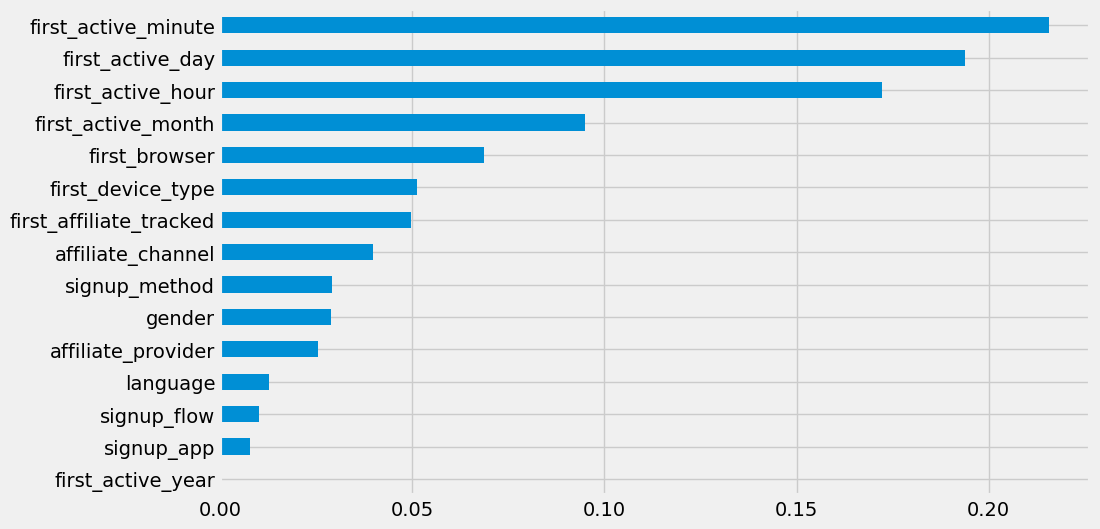

In [70]:
pd.Series(forest.feature_importances_, index=df[num_cols+cat_cols].columns).sort_values().plot(kind='barh');

In [71]:
forest_ = RandomForestClassifier(class_weight='balanced', random_state=42)
forest_.fit(X_train, y_train)

y_pred_rf_ = forest_.predict(X_test)
y_proba_rf_ = forest_.predict_proba(X_test)

y_test_multilabel_rf_ = label_binarize(y_test, classes=range(12))
print('Random Forest NDCG: ',ndcg_score(y_test_multilabel_rf_, y_proba_rf_, k=5),'\n')

Random Forest NDCG:  0.8368090935612108 



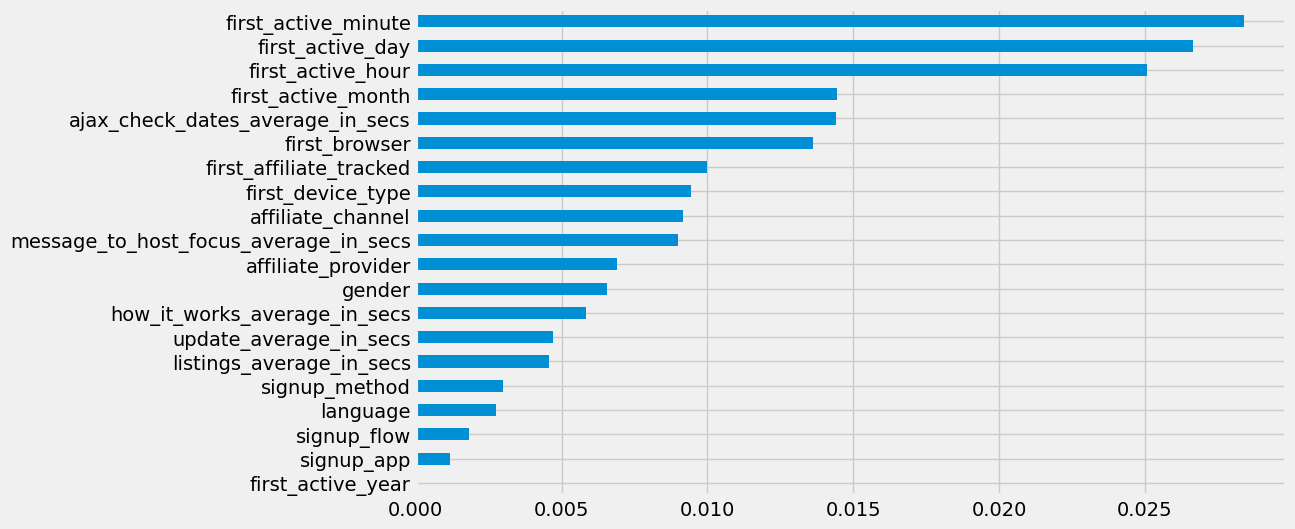

In [72]:
pd.Series(forest_.feature_importances_, index=X_train.columns)[:20].sort_values().plot(kind='barh');

### LightGBM Algorithm


In [73]:
lgb_clf = LGBMClassifier(objective='multiclass', random_state=42)
lgb_clf.fit(X_train.drop(text_cols, axis=1), y_train)

y_pred_lgb = lgb_clf.predict(X_test.drop(text_cols, axis=1))
y_proba_lgb = lgb_clf.predict_proba(X_test.drop(text_cols, axis=1))

y_test_multilabel_lgb = label_binarize(y_test, classes=range(12))
print('NDCG for LightGBM: ',ndcg_score(y_test_multilabel_lgb, y_proba_lgb, k=5),'\n')

NDCG for LightGBM:  0.8174916706936218 



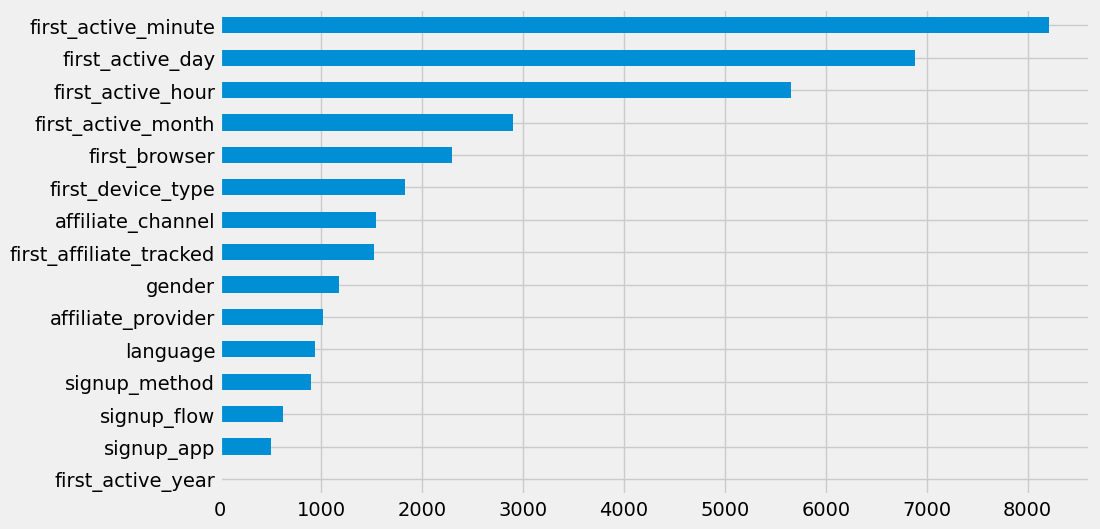

In [74]:
pd.Series(lgb_clf.feature_importances_, index=df[num_cols+cat_cols].columns).sort_values().plot(kind='barh');

In [75]:
lgb_clf_ = LGBMClassifier(objective='multiclass', random_state=42)
lgb_clf_.fit(X_train, y_train)

y_pred_lgb_ = lgb_clf_.predict(X_test)
y_proba_lgb_ = lgb_clf_.predict_proba(X_test)

y_test_multilabel_lgb_ = label_binarize(y_test, classes=range(12))
print('LightGBM NDCG: ',ndcg_score(y_test_multilabel_lgb_, y_proba_lgb_, k=5),'\n')

LightGBM NDCG:  0.8409264657734886 



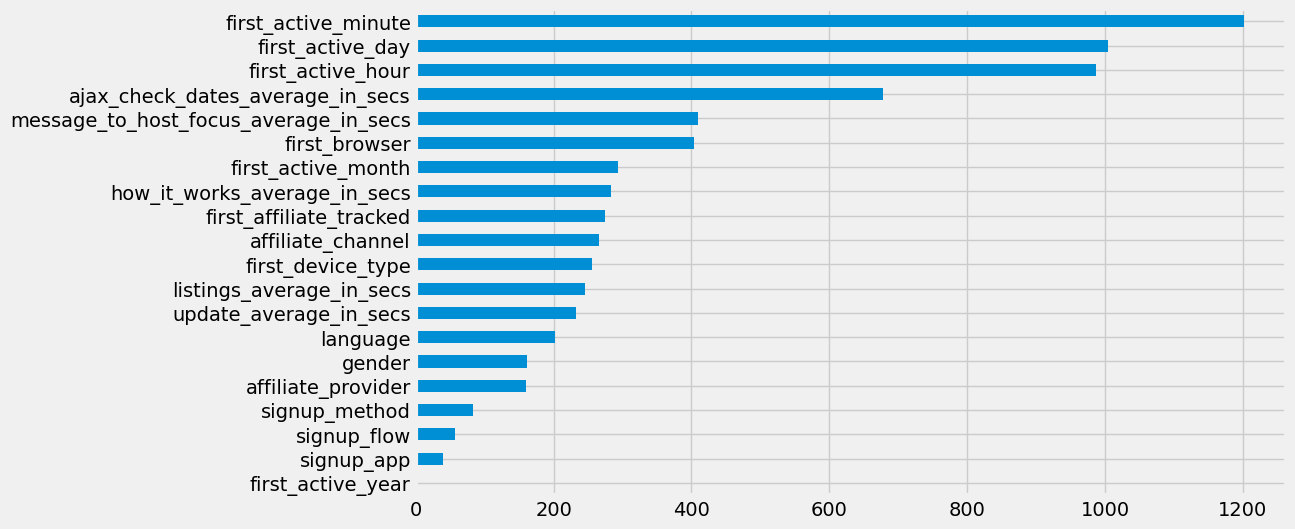

In [76]:
pd.Series(lgb_clf_.feature_importances_, index=X_train.columns)[:20].sort_values().plot(kind='barh');

### XGBoost Algorithm


In [77]:
xgb = XGBClassifier(n_estimators=5, random_state=42)
xgb.fit(X_train.drop(text_cols, axis=1), y_train)

y_pred_xgb = xgb.predict(X_test.drop(text_cols, axis=1))
y_proba_xgb = xgb.predict_proba(X_test.drop(text_cols, axis=1))

y_test_multilabel_xgb = label_binarize(y_test, classes=range(12))
print('NDCG score for XGBoost: ',ndcg_score(y_test_multilabel_xgb, y_proba_xgb, k=5),'\n')

NDCG score for XGBoost:  0.819485529683906 



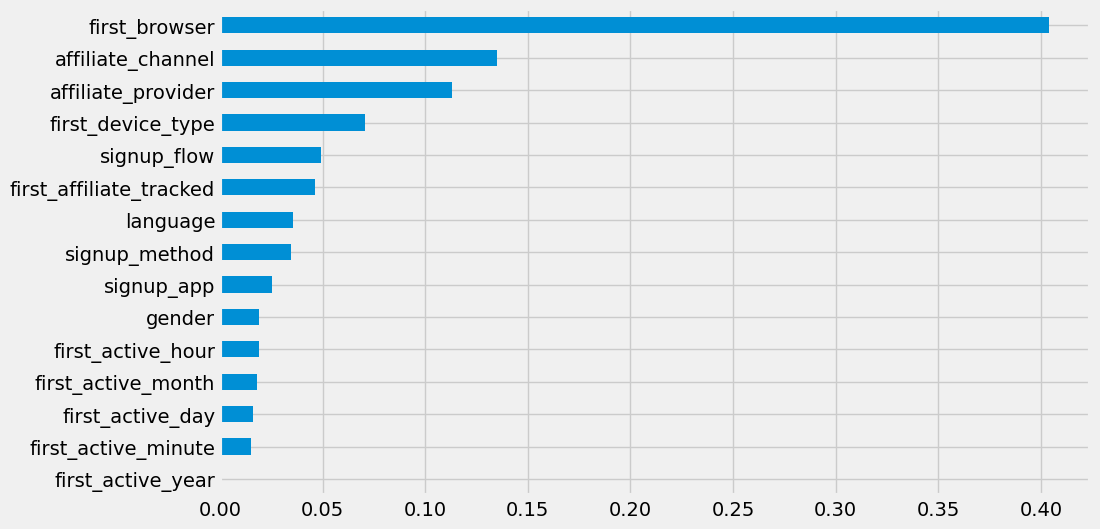

In [78]:
pd.Series(xgb.feature_importances_, index=df[num_cols+cat_cols].columns).sort_values().plot(kind='barh');

In [79]:
xgb_ = XGBClassifier(n_estimators=5, random_state=42)
xgb_.fit(X_train, y_train)

y_pred_xgb_ = xgb_.predict(X_test)
y_proba_xgb_ = xgb_.predict_proba(X_test)

y_test_multilabel_xgb_ = label_binarize(y_test, classes=range(12))
print('XGBoost NDCG: ',ndcg_score(y_test_multilabel_xgb_, y_proba_xgb_, k=5),'\n')

XGBoost NDCG:  0.842638742905932 



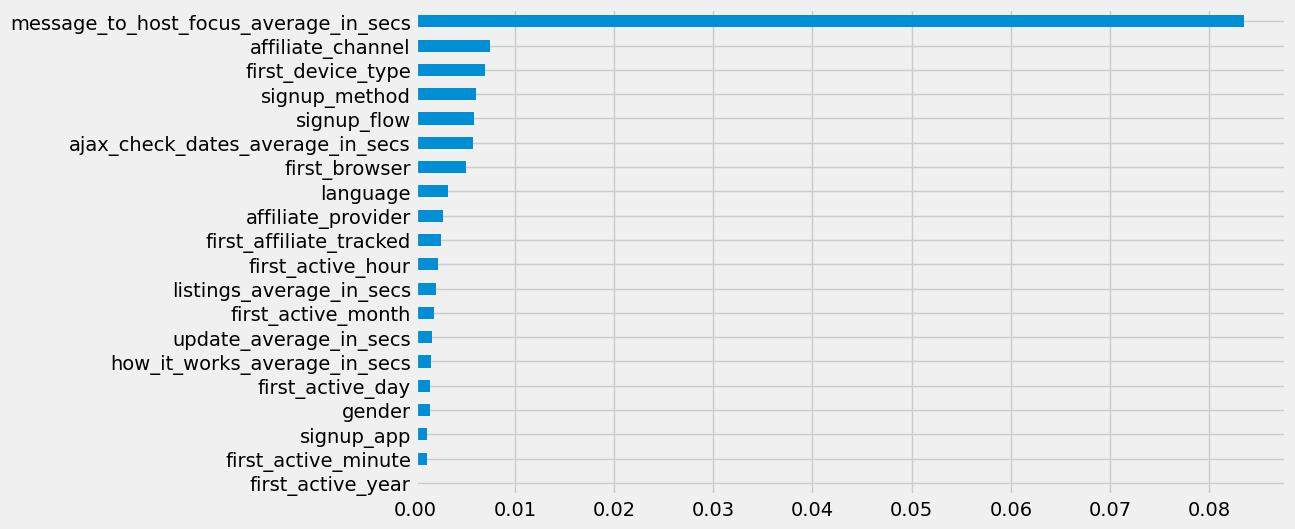

In [80]:
pd.Series(xgb_.feature_importances_, index=X_train.columns)[:20].sort_values().plot(kind='barh');

### CatBoost Algorithm

In [81]:
cb = CatBoostClassifier(random_state=42)
cb.fit(X_train.drop(text_cols, axis=1), y_train)

y_pred_cb = cb.predict(X_test.drop(text_cols, axis=1))
y_proba_cb = cb.predict_proba(X_test.drop(text_cols, axis=1))

Learning rate set to 0.097394
0:	learn: 2.0794808	total: 179ms	remaining: 2m 58s
1:	learn: 1.8689782	total: 298ms	remaining: 2m 28s
2:	learn: 1.7263864	total: 431ms	remaining: 2m 23s
3:	learn: 1.6194360	total: 556ms	remaining: 2m 18s
4:	learn: 1.5363042	total: 676ms	remaining: 2m 14s
5:	learn: 1.4696550	total: 809ms	remaining: 2m 14s
6:	learn: 1.4142957	total: 939ms	remaining: 2m 13s
7:	learn: 1.3684712	total: 1.08s	remaining: 2m 13s
8:	learn: 1.3303082	total: 1.24s	remaining: 2m 16s
9:	learn: 1.2978340	total: 1.48s	remaining: 2m 26s
10:	learn: 1.2700992	total: 1.68s	remaining: 2m 31s
11:	learn: 1.2465095	total: 1.92s	remaining: 2m 37s
12:	learn: 1.2260340	total: 2.15s	remaining: 2m 43s
13:	learn: 1.2083458	total: 2.4s	remaining: 2m 48s
14:	learn: 1.1931833	total: 2.64s	remaining: 2m 53s
15:	learn: 1.1799006	total: 2.89s	remaining: 2m 57s
16:	learn: 1.1684333	total: 3.13s	remaining: 3m
17:	learn: 1.1584803	total: 3.35s	remaining: 3m 2s
18:	learn: 1.1497986	total: 3.58s	remaining: 3m 4s

In [82]:
y_test_multilabel_cb = label_binarize(y_test, classes=range(12))
print('NDCG score for CatBoost: ',ndcg_score(y_test_multilabel_cb, y_proba_cb, k=5),'\n')

NDCG score for CatBoost:  0.8159261309423469 



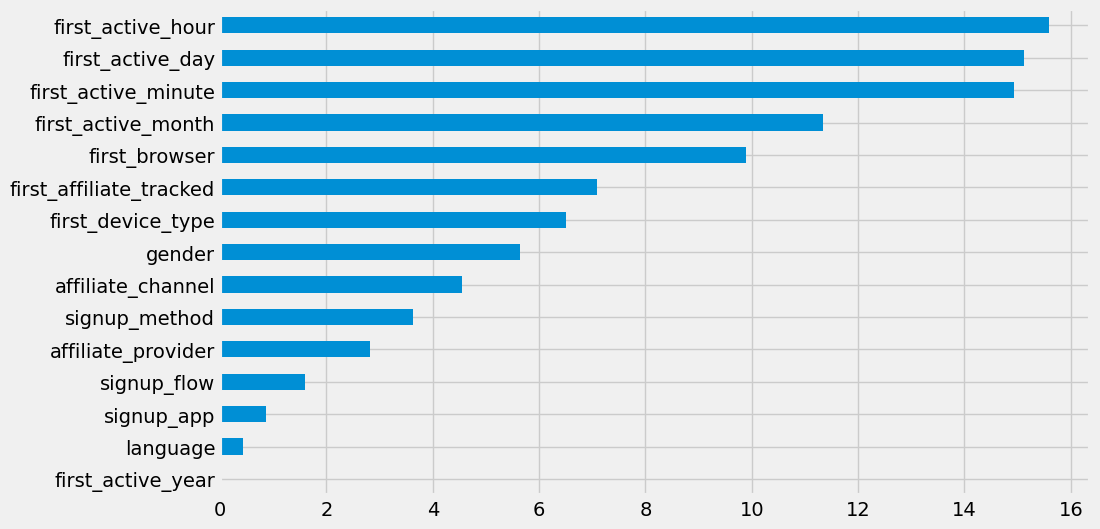

In [83]:
pd.Series(cb.feature_importances_, index=df[num_cols+cat_cols].columns)[:15].sort_values().plot(kind='barh');

In [ ]:
cb_ = CatBoostClassifier(random_state=42)
cb_.fit(X_train, y_train)

y_pred_cb_ = cb_.predict(X_test)
y_proba_cb_ = cb_.predict_proba(X_test)

Learning rate set to 0.097394
0:	learn: 2.0247020	total: 2.29s	remaining: 38m 11s
1:	learn: 1.8071889	total: 3.67s	remaining: 30m 31s
2:	learn: 1.6606559	total: 4.89s	remaining: 27m 4s
3:	learn: 1.5517859	total: 6.03s	remaining: 25m 1s
4:	learn: 1.4669338	total: 7.2s	remaining: 23m 53s
5:	learn: 1.3987925	total: 8.39s	remaining: 23m 10s
6:	learn: 1.3429956	total: 9.56s	remaining: 22m 36s
7:	learn: 1.2967005	total: 11.3s	remaining: 23m 16s
8:	learn: 1.2572782	total: 13.1s	remaining: 24m 5s
9:	learn: 1.2243752	total: 14.3s	remaining: 23m 36s
10:	learn: 1.1961231	total: 15.5s	remaining: 23m 13s
11:	learn: 1.1720094	total: 16.7s	remaining: 22m 51s
12:	learn: 1.1513938	total: 17.8s	remaining: 22m 34s
13:	learn: 1.1336447	total: 19s	remaining: 22m 20s
14:	learn: 1.1183461	total: 20.2s	remaining: 22m 7s
15:	learn: 1.1045201	total: 21.4s	remaining: 21m 54s
16:	learn: 1.0927790	total: 22.6s	remaining: 21m 45s
17:	learn: 1.0824369	total: 24.7s	remaining: 22m 27s
18:	learn: 1.0731087	total: 26.1s

In [ ]:
y_test_multilabel_cb_ = label_binarize(y_test, classes=range(12))
print('CatBoost NDCG: ',ndcg_score(y_test_multilabel_cb_, y_proba_cb_, k=5),'\n')

In [ ]:
pd.Series(cb_.feature_importances_, index=X_train.columns)[:20].sort_values().plot(kind='barh');

### Model optimization

In [ ]:
print('\tAlgorithm\t |\t NDGC score for User data\t |\t NDGC score for User & Sessions data')
print('\t----------------------------------------------------------------------------------------------------')
print('\tRandom Forest  \t |\t\t', round(ndcg_score(y_test_multilabel_rf, y_proba_rf, k=5),5),'\t\t |\t\t',round(ndcg_score(y_test_multilabel_rf_, y_proba_rf_, k=5),5))
print('\tLightGBM  \t |\t\t', round(ndcg_score(y_test_multilabel_lgb, y_proba_lgb, k=5),5),'\t\t |\t\t',round(ndcg_score(y_test_multilabel_lgb_, y_proba_lgb_, k=5),5))
print('\tCatBoost  \t |\t\t', round(ndcg_score(y_test_multilabel_cb, y_proba_cb, k=5),5),'\t\t |\t\t',round(ndcg_score(y_test_multilabel_cb_, y_proba_cb_, k=5),5))
print('\tXGBoost  \t |\t\t',round(ndcg_score(y_test_multilabel_xgb, y_proba_xgb, k=5),5),'\t\t |\t\t',round(ndcg_score(y_test_multilabel_xgb_, y_proba_xgb_, k=5),5))

	Algorithm	 |	 NDGC score for User data	 |	 NDGC score for User & Sessions data
	----------------------------------------------------------------------------------------------------
	Random Forest  	 |		 0.80224 		 |		 0.83594
	LightGBM  	 |		 0.81769 		 |		 0.84137
	CatBoost  	 |		 0.81561 		 |		 0.84298
	XGBoost  	 |		 0.81975 		 |		 0.84324


In [ ]:
xgb_params = {'eta': 0.1, 'subsample': 0.8, 'colsample_bytree': 0.6, 'seed': 2018, 'eval_metric': 'merror', 'objective': 'multi:softprob'}

max_depths = [4, 5, 6, 7]

for depth in max_depths:
    xgb_opt = XGBClassifier(max_depth=depth, **xgb_params)
    xgb_opt.fit(X_train, y_train)

    y_pred_opt_train = xgb_opt.predict(X_train)
    y_proba_opt_train = xgb_opt.predict_proba(X_train)

    y_pred_opt_test = xgb_opt.predict(X_test)
    y_proba_opt_test = xgb_opt.predict_proba(X_test)

    y_test_multilabel_opt_train = label_binarize(y_train, classes=range(12))
    print('XGBoost NDCG (train):', ndcg_score(y_test_multilabel_opt_train, y_proba_opt_train, k=5))

    y_test_multilabel_opt_test = label_binarize(y_test, classes=range(12))
    print('XGBoost NDCG (test):', ndcg_score(y_test_multilabel_opt_test, y_proba_opt_test, k=5))
    print()


[12:16:30] WARNING: ../src/learner.cc:767: 
Parameters: { "num_rounds" } are not used.

XGBoost NDCG (train): 0.8569732318512281
XGBoost NDCG (test): 0.8441214594001043

[12:20:56] WARNING: ../src/learner.cc:767: 
Parameters: { "num_rounds" } are not used.

XGBoost NDCG (train): 0.8641015318620727
XGBoost NDCG (test): 0.8435100337179771

[12:26:25] WARNING: ../src/learner.cc:767: 
Parameters: { "num_rounds" } are not used.

XGBoost NDCG (train): 0.8719017755221224
XGBoost NDCG (test): 0.8433937485544186

[12:33:05] WARNING: ../src/learner.cc:767: 
Parameters: { "num_rounds" } are not used.

XGBoost NDCG (train): 0.881119618957648
XGBoost NDCG (test): 0.8424914598746605



In [ ]:
xgb_params = {'subsample': 0.8, 'colsample_bytree': 0.6, 'seed': 2018, 'eval_metric': 'merror', 'objective': 'multi:softprob', 'max_depth':4}

etas = [0.08, 0.1, 0.12]

for eta in etas:
    xgb_opt = XGBClassifier(eta = eta, **xgb_params)
    xgb_opt.fit(X_train, y_train)

    y_pred_opt_train = xgb_opt.predict(X_train)
    y_proba_opt_train = xgb_opt.predict_proba(X_train)

    y_pred_opt_test = xgb_opt.predict(X_test)
    y_proba_opt_test = xgb_opt.predict_proba(X_test)

    y_test_multilabel_opt_train = label_binarize(y_train, classes=range(12))
    print('XGBoost NDCG (train):', ndcg_score(y_test_multilabel_opt_train, y_proba_opt_train, k=5))

    y_test_multilabel_opt_test = label_binarize(y_test, classes=range(12))
    print('XGBoost NDCG (test):', ndcg_score(y_test_multilabel_opt_test, y_proba_opt_test, k=5))
    print()


XGBoost NDCG (train): 0.8549994055039498
XGBoost NDCG (test): 0.8436995150041571

XGBoost NDCG (train): 0.8571687691696801
XGBoost NDCG (test): 0.8439954181875595

XGBoost NDCG (train): 0.8591698283176141
XGBoost NDCG (test): 0.8436370647746845

